In [6]:
from types import SimpleNamespace

d = dict(a=1, b=2, c=3, d=dict(e=4, f=5))
s = SimpleNamespace(**d)
print(s.a, s.b, s.c, s.d.e)
s.a = 4
print(s.a, s.b, s.c)

AttributeError: 'dict' object has no attribute 'e'

In [1]:
%cd ~/Code/bioplnn

/Users/valmiki/Code/bioplnn


/Users/valmiki/miniconda3/envs/python3.10/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [4]:
%cd /om2/user/valmiki/bioplnn/

[WinError 3] The system cannot find the path specified: '/om2/user/valmiki/bioplnn/'
c:\Users\valmi\Code\bioplnn\examples


c:\Users\valmi\miniconda3\envs\pytorch\lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import glob
import scipy
import os
from bioplnn.dataset import CIFAR10_V1
import matplotlib.pyplot as plt
from bioplnn.utils import flatten_indices
import torch_sparse
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def build_graph(path):
    connection = {}
    coordinates = []
    Nunits = []
    Adj = []
    weight_path = glob.glob(os.path.join(path, "*.npz"))[0]
    sparse_connection = scipy.sparse.load_npz(weight_path)
    mask_path = glob.glob(os.path.join(path, "*.npy"))
    if len(mask_path) == 1:
        masks = np.load(mask_path[0])
        layers = [np.stack(mask.nonzero()) for mask in masks[:-1]]
        Ny = masks.shape[2]
    else:
        layers = ["V1_indices", "V2_indices", "V3_indices", "V4_indices"]
        layers = [
            np.load(os.path.join(path, f"{layer}.npy")) for layer in layers
        ]
        Ny = 300

    for coor in layers:
        coordinates.append(coor[0] * Ny + coor[1])

    for i, incoming in enumerate(coordinates[:-1]):
        adj = torch.from_numpy(
            sparse_connection[coordinates[i + 1]][:, incoming].toarray()
        ).float()
        Adj.append(adj)

    return Adj

In [40]:
adj = torch.load("connection/sparse.pt").coalesce()
indices = adj.indices().long()
identity = indices.unique().tile(2, 1)
indices = torch.cat([indices, identity], 1)
values = torch.ones(indices.shape[1])

In [42]:
indices.shape[1]

190296

In [35]:
_, inv, fan_in = indices[0].unique(return_inverse=True, return_counts=True)
scale = torch.sqrt(2 / fan_in.float())
values = torch.randn(indices.shape[1]) * scale[inv]

In [39]:
scale[inv]

tensor([0.4264, 0.4264, 0.4264,  ..., 1.0000, 0.4264, 1.0000])

In [29]:
fan_in = indices[0].unique(return_counts=True)[1].float().mean()
fan_out = indices[1].unique(return_counts=True)[1].float().mean()
values = torch.randn(indices.shape[1]) * math.sqrt(2 / (fan_in + fan_out))

In [20]:
values = torch.randn(indices.shape[1])
for i in range(2):
    _, inv, count = indices[i].unique(return_inverse=True, return_counts=True)
    scale = torch.sqrt(1 / count)
    values[inv] = values[inv] * scale.repeat_interleave(count)

In [21]:
values

tensor([-0.0600,  0.0812, -0.2224,  ...,  0.0260,  0.0994,  1.5058])

In [12]:
_, inv, count = indices[0].unique(return_inverse=True, return_counts=True)
scale = torch.sqrt(1 / count)

In [14]:
values = torch.randn(indices.shape[1]) * scale.repeat_interleave(count)

In [18]:
indices[0]

tensor([   35,    35,    35,  ..., 33479, 33750, 33750])

In [17]:
count.repeat_interleave(count)

tensor([11, 11, 11,  ..., 11,  2,  2])

In [15]:
values

tensor([ 0.4319, -0.3683,  0.1432,  ..., -0.1374, -0.0431,  0.1445])

In [102]:
adj = torch.load("connection/sparse.pt").to(device).coalesce()
indices = adj.indices().long()
identity = indices.unique().tile(2, 1)
indices_new = torch.cat([indices, identity], 1)
values = torch.ones(indices_new.shape[1], device=device)
adj_new = torch.sparse_coo_tensor(indices_new, values, adj.shape).coalesce()
adj_inv = adj.t().coalesce()

In [103]:
adj.indices()

tensor([[   35,    35,    35,  ..., 33479, 33479, 33750],
        [   64,    68,    69,  ..., 28677, 28976, 29555]], device='cuda:0')

In [104]:
adj.t().coalesce().indices()

tensor([[   50,    50,    50,  ..., 31363, 31363, 31363],
        [   45,    49,   344,  ..., 32560, 32565, 32861]], device='cuda:0')

In [105]:
adj_new.indices()

tensor([[   35,    35,    35,  ..., 33479, 33750, 33750],
        [   35,    64,    68,  ..., 33479, 29555, 33750]], device='cuda:0')

In [107]:
adj_new.t().coalesce().indices()

tensor([[   35,    36,    37,  ..., 33476, 33479, 33750],
        [   35,    36,    37,  ..., 33476, 33479, 33750]], device='cuda:0')

In [109]:
(adj.indices() == adj.t().coalesce().indices()).count_nonzero()

tensor(17, device='cuda:0')

In [111]:
adj_new.indices()[0].unique(return_counts=True)[1].float().mean()

tensor(8.9505, device='cuda:0')

In [94]:
indices[1].unique(return_counts=True)[1].float().mean()

tensor(9.9991)

In [ ]:
adj.indices()[0].unique(return_counts=True)[1].float().mean()

tensor(8.9505)

In [64]:
adj.indices()

tensor([[   35,    35,    35,  ..., 33479, 33750, 33750],
        [   35,    64,    68,  ..., 33479, 29555, 33750]])

In [68]:
adj_inv.indices()

tensor([[   35,    36,    37,  ..., 33476, 33479, 33750],
        [   35,    36,    37,  ..., 33476, 33479, 33750]])

In [96]:
(indices[0] == indices[1]).count_nonzero()

tensor(0)

In [55]:
(indices[0] == indices[1]).count_nonzero()

tensor(21261)

In [42]:
indices_new[1].unique(return_counts=True)[1].float().mean()

tensor(9.9991)

In [26]:
adj[0, 0]

tensor(0.)

In [ ]:
connections = adj.to_dense().count_nonzero(dim=1)
connections[connections.nonzero(as_tuple=True)].float().mean()

In [12]:
indices[1].unique(return_counts=True)[1].float().mean()

tensor(8.9505)

In [1]:
path = "connection"
sparse_connection = (
    torch.load(os.path.join(path, "sparse.pt")).coalesce().to(device)
)

NameError: name 'torch' is not defined

In [68]:
indices = sparse_connection.indices().to(device)
identity = indices.unique().tile(2, 1)
indices = torch.cat([indices, identity], 1)
values = torch.ones(indices.shape[1], device=device)

In [79]:
w = torch.sparse_coo_tensor(
    indices, values, sparse_connection.shape, device=device
).coalesce()

In [80]:
inverse_indices = torch.stack((indices[1], indices[0]))
w_inv = torch.sparse_coo_tensor(
    inverse_indices, values, sparse_connection.shape, device=device
).coalesce()

In [65]:
indices[0].unique().shape

torch.Size([21261])

In [67]:
sparse_connection.values()

tensor([-1.2241, -0.6700, -1.5396,  ...,  1.4833, -0.2677,  1.8373],
       device='cuda:0', dtype=torch.float64)

In [31]:
connections = sparse_connection.count_nonzero(dim=1)
connections[connections.nonzero(as_tuple=True)].float().mean()

tensor(10.8862, device='cuda:0')

In [23]:
layers = ["V1_indices", "V2_indices", "V3_indices", "V4_indices"]
coordinates = [
    torch.tensor(np.load(os.path.join(path, f"{layer}.npy")))
    for layer in layers
]
Ny = 300
coordinates1d = [flatten_indices(coor) for coor in coordinates]
for coor, layer in zip(coordinates, layers):
    torch.save(coor, os.path.join(path, f"{layer}.pt"))
for coor, layer in zip(coordinates1d, layers):
    torch.save(coor, os.path.join(path, f"{layer}_flat.pt"))

In [28]:
x = torch.zeros(16, 3, 1024)
x = x.flatten(2)
print(x.shape)
x.mean(dim=1).shape

torch.Size([16, 3, 1024])


torch.Size([16, 1024])

In [22]:
for layer in layers:
    os.remove(os.path.join(path, f"{layer}_flat.pt"))

In [16]:
sparse_connection = sparse_connection.to("cuda")

In [29]:
indices = sparse_connection.indices()
indices[1, :].unique()

tensor([   50,    51,    52,  ..., 31361, 31362, 31363], device='cuda:0')

In [ ]:
weight_path = os.path.join(path, "sparse.npz")
sparse_connection = scipy.sparse.load_npz(weight_path)

In [36]:
values = torch.ones_like(coordinates[0]).float()

In [42]:
pic = torch.ones(150, 300)
for coordinate in coordinates:
    pic[coordinate[0], coordinate[1]] = 0

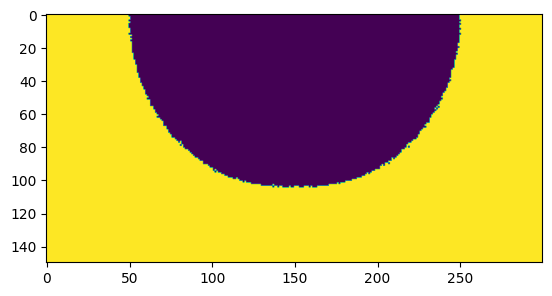

In [43]:
import matplotlib.pyplot as plt

plt.imshow(pic)

In [ ]:
torch.sparse_coo_tensor(
    coordinates[0], values, (150, 300), device="cuda"
).to_dense()